# Example of using the PyRadiomics toolbox in Python

First, import some built-in Python modules needed to get our testing data.
Second, import the toolbox, only the `featureextractor` is needed, this module handles the interaction with other parts of the toolbox.

In [389]:
from __future__ import print_function
import six
import glob, os, sys  # needed navigate the system to get the input data

# features are described at https://pyradiomics.readthedocs.io/en/latest/features.html
import radiomics
from radiomics import featureextractor  # This module is used for interaction with pyradiomics

import SimpleITK as sitk
import numpy as np
import pandas as pd
import cv2 

### Setting up data

Test cases can be downloaded to temporary files. This is handled by the `radiomics.getTestCase()` function, which checks if the requested test case is available and if not, downloads it. It returns a tuple with the location of the image and mask of the requested test case, or (None, None) if it fails.

Alternatively, if the data is available somewhere locally, this directory can be passed as a second argument to `radiomics.getTestCase()`. If that directory does not exist or does not contain the testcase, functionality reverts to default and tries to download the test data.

If getting the test case fails, PyRadiomics will log an error explaining the cause.

In [390]:
os.getcwd()

'/home/pablo/dev/radioterapia/fluence_maps/radiomics'

### Create mask file _mask.nrrd_ including almost all pixels
If all pixels are included (0, 0, 255, 255) the mask is not created, so I created a (1, 1, 254, 254) mask.

In [391]:
def createMask(image, maskPath):
    point = (int(image_size[0]/2), int(image_size[1]/2))  # fill in the index of your point here
    # (254, 254) excluyo 1 pixel de cada lado
    roi_size = (image_size[0]-2, image_size[1]-2)  # x, y, z; uneven to ensure the point is really the center of your ROI

    ma_arr = np.zeros(image_size, dtype='uint8')

    # Compute lower and upper bound of the ROI
    L_x = point[0] - int((roi_size[0]) / 2)
    L_y = point[1] - int((roi_size[1]) / 2)

    U_x = point[0] + int((roi_size[0] - 1) / 2)
    U_y = point[1] + int((roi_size[1] - 1) / 2)

    # ensure the ROI stays within the image bounds
    L_x = max(0, L_x)
    L_y = max(0, L_y)

    U_x = min(image_size[1] - 1, U_x)
    U_y = min(image_size[0] - 1, U_y)

    print(L_x, L_y, U_x, U_y)

    # 'segment' the mask
    ma_arr[L_y:U_y + 1, L_x:U_x+1] = 1  # Add + 1 to each slice, as slicing is done from lower bound to, but not including, upper bound. Because we do want to include our upper bound, add + 1
    print(ma_arr)

    ma = sitk.GetImageFromArray(ma_arr)
    ma.CopyInformation(image)  # This copies the geometric information, ensuring image and mask are aligned. This works, because image and mask have the same size of the pixel array

    sitk.WriteImage(ma, maskPath, True)  # don't forget the extension!, True specifies it can be compressed for storage (only used for masks

### Create mask file _contoursMask.nrrd_ using finding countours

In [392]:
def createMaskFromContours(imagePath, maskPath, debug=False):
    image = cv2.imread(imagePath) 

    # Finding Contours 
    # Use a copy of the image e.g. imgray.copy() since findContours alters the image 
    imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Second output is our thresholded image.
    # 20 is threshold, 255 is max value
    ret, thresh = cv2.threshold(imgray, 20, 255, 0)

    # contours is a Python list of all the contours in the image.
    # Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.
    image, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # for debugging only
    if debug:
        print(imagePath)
        print("Number of Contours found = " + str(len(contours)))
        plt.imshow(image, cmap = 'gray')

    ma_arr = image
    ma_arr = np.where(ma_arr == 255, 1, ma_arr)

    ma = sitk.GetImageFromArray(ma_arr)

    sitk.WriteImage(ma, maskPath, True)

In [393]:
ARG_SOURCE_PATH='/hdd/data/radioterapia/ciolaplata'
ARG_DICOM_AND_GAMMA_CSV = "codex.2019-2018-2017.3mm3%Doseshift10%-localnorm-sinoutliers74.csv" # 7244 casos
ARG_TEXTURE_FEATURES_CSV='2019-2018-2017.texture-features.csv'
ARG_SEED=23456 # t-SNE
image_filename = '1.3.6.1.4.1.9590.100.1.2.104687111612620525338811872261145275128.jpeg' # 1 contour
# image_filename = '1.3.6.1.4.1.9590.100.1.2.413026936412366497424912997123899479271.jpeg' # 1 contour
# image_filename = '1.3.6.1.4.1.9590.100.1.2.149022879910701913634657645393318300150.jpeg' # 3 contours with thres = 25, 2 with thres = 20
# image_filename = '1.3.6.1.4.1.9590.100.1.2.68178121113821334525403915874018401462.jpeg' # 4 contours with thres = 25, 1 with thres = 20
# image_filename = '1.3.6.1.4.1.9590.100.1.2.76296562210273102234514513081279675861.jpeg' # 3 contours with thres = 25, 1 also with thres = 20
imagePath = os.path.join(ARG_SOURCE_PATH, '2017-opencv-jpeg', image_filename)
ARG_CONTOUR_MASK=False # TODO: no me resultó, requiere seguir investigando
mask_filename = 'mask.nrrd'
if ARG_CONTOUR_MASK:
    mask_filename = 'contoursMask.nrrd'
ARG_MASK_PATH = os.path.join(ARG_SOURCE_PATH, mask_filename)

ARG_EXTRACT_FEATURES=True
ARG_EXTRACT_GLCM_SEPARATED_FEATURES=True

In [394]:
image_1 = sitk.ReadImage(imagePath)
# [::-1] es iterable[inicio:fin:paso]
image_size = image_1.GetSize()[::-1]  # size in z, y, x, needed because the arrays obtained from the image are oriented in z, y, x
print(image_size)

# uncomment if you need to recreate mask file 'mask.nrrd'
# createMask(image_1, ARG_MASK_PATH)
# createMaskFromContours(imagePath, ARG_MASK_PATH, debug=True)

(256, 256)


In [395]:
label_1 = sitk.ReadImage(ARG_MASK_PATH)
image_size = label_1.GetSize()[::-1]
print(image_size)

(256, 256)


### Find countours
For experimentation: cv2.threshold() parameters differ from those in createMaskFromContours()

Number of Contours found = 1


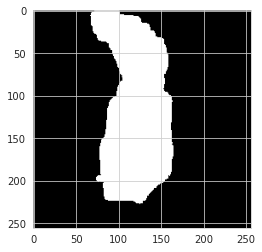

In [396]:
import cv2 
import numpy as np 
  
image = cv2.imread(imagePath) 

# Finding Contours 
# Use a copy of the image e.g. imgray.copy() since findContours alters the image 
imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Second output is our thresholded image.
# 25 is threshold, 255 is max value
ret, thresh = cv2.threshold(imgray, 25, 255, 0)

# contours is a Python list of all the contours in the image.
# Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.
image, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

print("Number of Contours found = " + str(len(contours)))

plt.imshow(image, cmap = 'gray')

### Show the images

Using `matplotlib.pyplot` (referenced as `plt`), display the images in grayscale and labels in color.

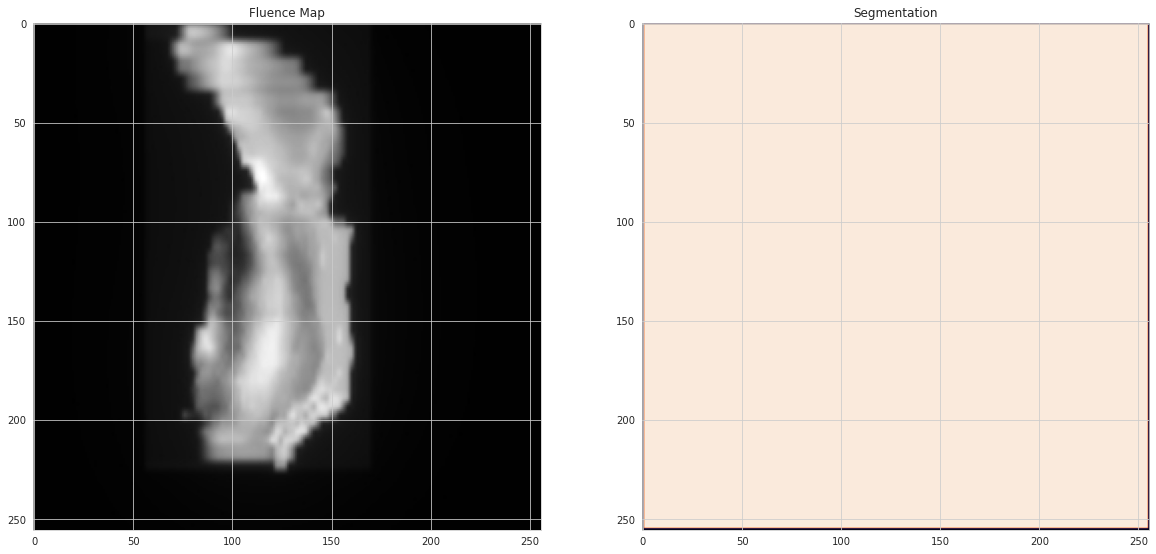

In [397]:
# Display the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))

# 1 row, 2 columns, plot 1
plt.subplot(1,2,1)
plt.imshow(sitk.GetArrayFromImage(image_1)[:,:], cmap="gray")
plt.title("Fluence Map")
# 1 row, 2 columns, plot 2
plt.subplot(1,2,2)
plt.imshow(sitk.GetArrayFromImage(label_1)[:,:])        
plt.title("Segmentation")

plt.show()

## Extract the features

Using the `radiomics` package, first construct an `extractor` object from the parameters set in `Params.yaml`.  Then generate features for the two images.

In [398]:
# Additonally, store the location of the example parameter file, stored in \pyradiomics\examples/exampleSettings
paramPath = os.path.join('.', 'rtParams.yaml')
print('Parameter file, absolute path:', os.path.abspath(paramPath))

Parameter file, absolute path: /home/pablo/dev/radioterapia/fluence_maps/radiomics/rtParams.yaml


### Instantiating the extractor

Now that we have our input, we need to define the parameters and instantiate the extractor.
For this there are three possibilities:

1. Use defaults, don't define custom settings

2. Define parameters in a dictionary, control filters and features after initialisation

3. Use a parameter file

##### Method 3, using a parameter file

In [399]:
# radiomics.setVerbosity(10) # 10: Log messages of level “DEBUG” and up are printed (i.e. all log messages)

# Instantiate the extractor
extractor = featureextractor.RadiomicsFeatureExtractor(paramPath)

print('Extraction parameters:\n\t', extractor.settings)
print('Enabled filters:\n\t', extractor.enabledImagetypes)
print('Enabled features:\n\t', extractor.enabledFeatures)

Extraction parameters:
	 {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1, 2, 4, 8], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 16, 'weightingNorm': None}
Enabled filters:
	 {'Original': {}}
Enabled features:
	 {'firstorder': ['10Percentile', '90Percentile', 'Energy', 'Entropy', 'InterquartileRange', 'Kurtosis', 'MeanAbsoluteDeviation', 'Mean', 'Range', 'RobustMeanAbsoluteDeviation', 'RootMeanSquared', 'Skewness', 'TotalEnergy', 'Uniformity', 'Variance'], 'glcm': ['Autocorrelation', 'JointAverage', 'ClusterProminence', 'ClusterShade', 'ClusterTendency', 'Contrast', 'Correlation', 'DifferenceAverage', 'DifferenceEntropy', 'DifferenceVariance', 'JointEnergy', 'JointEntropy', 'Imc1', 'Imc2', 'Idm', 'MCC', 'Idmn', 'Id', 'Idn', 'InverseVarianc

### Extract features

Now that we have our extractor set up with the correct parameters, we can start extracting features:

In [400]:
result = extractor.execute(imagePath, ARG_MASK_PATH)

In [401]:
print('Result type:', type(result))  # result is returned in a Python ordered dictionary)
print('')
print('Calculated features')
for key, value in six.iteritems(result):
    print('\t', key, ':', value)

Result type: <class 'collections.OrderedDict'>

Calculated features
	 diagnostics_Versions_PyRadiomics : v3.0.1
	 diagnostics_Versions_Numpy : 1.19.2
	 diagnostics_Versions_SimpleITK : 2.0.2
	 diagnostics_Versions_PyWavelet : 1.1.1
	 diagnostics_Versions_Python : 3.7.5
	 diagnostics_Configuration_Settings : {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1, 2, 4, 8], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 16, 'weightingNorm': None}
	 diagnostics_Configuration_EnabledImageTypes : {'Original': {}}
	 diagnostics_Image-original_Hash : ab636049276bca74c316ed609b655d4bca28c476
	 diagnostics_Image-original_Dimensionality : 2D
	 diagnostics_Image-original_Spacing : (1.0, 1.0)
	 diagnostics_Image-original_Size : (256, 256)
	 diagnostics_Image-o

### Extract GLCM using scikit-image

In [402]:
# The GLCM Tutorial Home Page,
#       http://www.fp.ucalgary.ca/mhallbey/tutorial.htm       
from skimage.feature import greycomatrix, greycoprops
from skimage import io  

image = io.imread(imagePath)

xs = []
ys = []
# Todas las métricas para las distintas distancias están correlacionadas con r > 0.9, entonces sólo uso d = 5
# las métrics 'energy' y 'ASM' tienen una correlación r = 1.0 para todas las distancias y todos los ángulos, entonces sólo uso d = 5 y a = 0
# distances = [1, 2, 4, 8] # d: list of pixel pair distance offsets.
distances = [5]
angles = [0, np.pi*1/4, np.pi*2/4, np.pi*3/4] # a: list of pixel pair angles in radians. Para todas las métricas excepto 'energy' y 'ASM'
a_degress = (np.array(angles)*180/np.pi).astype(np.int)
glcm = greycomatrix(image, distances=distances, angles=angles, levels=256,
                    symmetric=True, normed=True)
xs.append(greycoprops(glcm, 'dissimilarity')[0, 0])
ys.append(greycoprops(glcm, 'correlation')[0, 0])

In [403]:
glcm[:, :, 0, 3].shape

(256, 256)

In [404]:
# results : 2-D ndarray
#    2-dimensional array. `results[d, a]` is the property 'prop' for
#    the d'th distance and the a'th angle.
# ex.: results[2, 1] is results[d=4, a=45]
greycoprops(glcm, 'dissimilarity')

array([[9.1 , 8.25, 4.77, 8.63]])

In [405]:
def extract_gclm_separated(image):
    distances = [5] # d: list of pixel pair distance offsets.
    angles = [0, np.pi*1/4, np.pi*2/4, np.pi*3/4] # a: list of pixel pair angles in radians.
    a_degress = (np.array(angles)*180/np.pi).astype(np.int)
    
    # la matriz se calcula para todas las distancias y ángulos,
    # pero las métricas no, sólo para las distancias y ángulos de interés.
    glcm = greycomatrix(image, distances=distances, angles=angles, levels=256,
                        symmetric=True, normed=True)
    
    glcm_dict = {}
    features = ['contrast', 'dissimilarity', 'homogeneity', 'correlation']
    for f_name in features:
        m = greycoprops(glcm, f_name)
        for d in range(0, len(distances)):
            for a in range(0, len(angles)):
                name = 'glcmsep_'+f_name+'_'+str(distances[d])+'_'+str(a_degress[a])
                glcm_dict[name] = m[d, a]
                
    
    angles = [0]
    
    features = ['energy', 'ASM']
    for f_name in features:
        m = greycoprops(glcm, f_name)
        for d in range(0, len(distances)):
            for a in range(0, len(angles)):
                name = 'glcmsep_'+f_name+'_'+str(distances[d])+'_'+str(a_degress[a])
                glcm_dict[name] = m[d, a]
                
    return glcm_dict

In [406]:
glcm_dict=extract_gclm_separated(image)
print('Se extraen {} GCLM features separadas.'.format(len([*glcm_dict])))
[*glcm_dict] # https://www.python.org/dev/peps/pep-0448/

Se extraen 18 GCLM features separadas.


['glcmsep_contrast_5_0',
 'glcmsep_contrast_5_45',
 'glcmsep_contrast_5_90',
 'glcmsep_contrast_5_135',
 'glcmsep_dissimilarity_5_0',
 'glcmsep_dissimilarity_5_45',
 'glcmsep_dissimilarity_5_90',
 'glcmsep_dissimilarity_5_135',
 'glcmsep_homogeneity_5_0',
 'glcmsep_homogeneity_5_45',
 'glcmsep_homogeneity_5_90',
 'glcmsep_homogeneity_5_135',
 'glcmsep_correlation_5_0',
 'glcmsep_correlation_5_45',
 'glcmsep_correlation_5_90',
 'glcmsep_correlation_5_135',
 'glcmsep_energy_5_0',
 'glcmsep_ASM_5_0']

In [407]:
def getFeatureNames(result, glcm_dict, glcm_sep=False):
    # tomar los keys del diccionario result que empiezan con 'original_'
    # y armar una lista, las que van a ser las columnas del dataframe de features
    # feature_names = [key[len('original_'):] for key in result.keys() if key.startswith('original_')]
    # le dejo el prefijo 'original_' y se lo saco después
    feature_names = [key for key in result.keys() if key.startswith('original_')]
    if glcm_sep:
        feature_names = feature_names + [*glcm_dict]
    return feature_names

In [408]:
def getRenamedFeatureNames(result, glcm_dict, glcm_sep=False):
    # tomar los keys del diccionario result que empiezan con 'original_'
    # y armar una lista, las que van a ser las columnas del dataframe de features
    # remuevo el prefijo 'original_'
    feature_names = [key[len('original_'):] for key in result.keys() if key.startswith('original_')]
    if glcm_sep:
        feature_names = feature_names + [*glcm_dict]
    return feature_names

In [409]:
renamed_feature_names = getRenamedFeatureNames(result, glcm_dict, ARG_EXTRACT_GLCM_SEPARATED_FEATURES)

## Extract features for each .jpeg file in folder and generate .csv with features

In [410]:
def build_jpeg_filename(base, year, filename):
    return os.path.join(base, year + '-opencv-jpeg', filename + '.jpeg')

In [411]:
def extractFeatures(df, glcm_sep=False):
    i = 0
    for file in df['jpeg_full_filepath'].values:
        try:
            image = sitk.ReadImage(file)
            shape = image.GetSize()[::-1]
            assert len(shape) == 2, "JPEG files are not grey level (i.e.: do not have 2 channels)"
            assert shape[0] == 256 and shape[1] == 256, "JPEG files are not of size 256x256"

            if ARG_CONTOUR_MASK:
                # generar la máscara para cada imagen
                createMaskFromContours(file, ARG_MASK_PATH)
            
            result = extractor.execute(file, ARG_MASK_PATH)
            for key in result.keys():
                if key.startswith('original_'):
                    df.loc[i, key] = result.get(key)

            if glcm_sep:
                # read image file again using scikit-image
                image = io.imread(file)
                glcm_dict=extract_gclm_separated(image)
                for key in glcm_dict.keys():
                    df.loc[i, key] = glcm_dict.get(key)
            
            sys.stdout.write('\r>> Features extracted for image %d/%d.' % (i+1, N))
            sys.stdout.flush()
            i += 1

        except OSError as err:
            print('Could not extract features for file {}, error: {}'.format(file, err))

    sys.stdout.write('\n')
    sys.stdout.flush()
    
    return df

In [412]:
if ARG_EXTRACT_FEATURES:
    source_folder = ARG_SOURCE_PATH

    gamma_csv = os.path.join(source_folder, ARG_DICOM_AND_GAMMA_CSV)
    df_dcm_in = pd.read_csv(gamma_csv, sep=';', delimiter=None, header=0)
    N = len(df_dcm_in)
    feature_names = getFeatureNames(result, glcm_dict, ARG_EXTRACT_GLCM_SEPARATED_FEATURES)
    print("Se extraerán {} features para cada uno de los {} archivos JPEG en {}.".format(len(feature_names), N, gamma_csv))

    # agrego una columna constante al dataframe para hacer más simple el armado del full file path de los archivos dicom
    df_dcm_in['base_dir'] = source_folder

    df_features_out = pd.DataFrame(columns=['jpeg_full_filepath', 'gamma_index'] + feature_names)
    df_features_out['jpeg_full_filepath'] = [build_jpeg_filename(row[0], str(row[1]), row[2]) for row in df_dcm_in[['base_dir', 'año', 'fluencia calculada']].values]
    df_features_out['gamma_index'] = df_dcm_in.apply(lambda row: 100.0 - row['uno menos gamma index'], axis=1)


    # df_features_out.loc[:, ['jpeg_full_filepath','gamma_index','firstorder_10Percentile','glszm_LowGrayLevelZoneEmphasis']]
    df_features_out[['jpeg_full_filepath','gamma_index','original_firstorder_10Percentile','original_glszm_LowGrayLevelZoneEmphasis']]

    # extract features
    df_features = extractFeatures(df_features_out, ARG_EXTRACT_GLCM_SEPARATED_FEATURES)

    df_features.columns= ['jpeg_full_filepath', 'gamma_index'] + renamed_feature_names

    texture_features_csv = os.path.join(ARG_SOURCE_PATH, ARG_TEXTURE_FEATURES_CSV)
    df_features.to_csv(texture_features_csv, index=False)
    print(f'Texture features .csv file saved to {texture_features_csv}.\n')

Se extraerán 107 features para cada uno de los 7244 archivos JPEG en /hdd/data/radioterapia/ciolaplata/codex.2019-2018-2017.3mm3%Doseshift10%-localnorm-sinoutliers74.csv.
>> Features extracted for image 7244/7244.
Texture features .csv file saved to /hdd/data/radioterapia/ciolaplata/2019-2018-2017.texture-features.csv.



## Load features from .csv

In [413]:
def gamma_interval(gamma_value):
    if gamma_value < 95.0:
        interval = "< 95%"
    elif gamma_value >= 95.0:
        interval = ">= 95%"
    
    return interval

In [414]:
texture_features_csv = os.path.join(ARG_SOURCE_PATH, ARG_TEXTURE_FEATURES_CSV)
df_features_copy = pd.read_csv(texture_features_csv, delimiter=None, header=0)
df_features_copy['gamma interval'] = [gamma_interval(value) for value in df_features_copy['gamma_index']]
df_features_copy

,jpeg_full_filepath,gamma_index,firstorder_10Percentile,firstorder_90Percentile,firstorder_Energy,firstorder_Entropy,firstorder_InterquartileRange,firstorder_Kurtosis,firstorder_MeanAbsoluteDeviation,firstorder_Mean,...,glcmsep_homogeneity_5_45,glcmsep_homogeneity_5_90,glcmsep_homogeneity_5_135,glcmsep_correlation_5_0,glcmsep_correlation_5_45,glcmsep_correlation_5_90,glcmsep_correlation_5_135,glcmsep_energy_5_0,glcmsep_ASM_5_0,gamma interval
0,/hdd/data/radioterapia/ciolaplata/2017-opencv-...,74.161700,1.0,108.0,169714246.0,1.409967,8.0,8.201476,31.090191,21.682466,...,0.675192,0.734153,0.685249,0.963681,0.947032,0.960970,0.956780,0.391329,0.153139,< 95%
1,/hdd/data/radioterapia/ciolaplata/2017-opencv-...,74.333400,0.0,98.0,139138467.0,1.326575,11.0,7.720804,28.891244,20.232175,...,0.692756,0.754564,0.696850,0.934003,0.938034,0.965054,0.933485,0.366417,0.134262,< 95%
2,/hdd/data/radioterapia/ciolaplata/2017-opencv-...,74.338600,0.0,58.0,99913634.0,1.005641,3.0,15.405680,21.145489,13.831980,...,0.773535,0.806708,0.753169,0.943875,0.948941,0.956787,0.923593,0.431409,0.186114,< 95%
3,/hdd/data/radioterapia/ciolaplata/2017-opencv-...,74.513800,0.0,83.0,128906260.0,1.440375,10.0,9.251933,27.335058,19.378821,...,0.689136,0.757079,0.686511,0.941446,0.947786,0.964715,0.932355,0.372224,0.138551,< 95%
4,/hdd/data/radioterapia/ciolaplata/2017-opencv-...,74.604800,0.0,78.0,117370763.0,1.217082,4.0,10.936360,24.376303,16.824028,...,0.712840,0.795125,0.717974,0.924342,0.924818,0.963128,0.933728,0.370250,0.137085,< 95%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7239,/hdd/data/radioterapia/ciolaplata/2018-opencv-...,99.908812,0.0,9.0,83280566.0,0.583911,1.0,25.537757,14.739190,8.897886,...,0.838608,0.870402,0.852949,0.924654,0.894570,0.946719,0.943147,0.565024,0.319252,>= 95%
7240,/hdd/data/radioterapia/ciolaplata/2018-opencv-...,99.916852,0.0,11.0,74654133.0,0.662084,1.0,23.457868,14.848130,9.020724,...,0.837322,0.862276,0.834028,0.931610,0.925692,0.947887,0.924572,0.556833,0.310063,>= 95%
7241,/hdd/data/radioterapia/ciolaplata/2018-opencv-...,99.922824,0.0,16.0,117385116.0,0.841256,2.0,16.516823,20.411125,12.907186,...,0.791731,0.820067,0.796163,0.939045,0.926697,0.954788,0.943066,0.463235,0.214586,>= 95%
7242,/hdd/data/radioterapia/ciolaplata/2018-opencv-...,99.935760,0.0,1.0,13096240.0,0.229801,0.0,148.478327,3.673611,2.020770,...,0.929208,0.937001,0.930572,0.838249,0.781295,0.834829,0.827300,0.874735,0.765162,>= 95%


In [415]:
counts = df_features_copy.groupby(['gamma interval'])['jpeg_full_filepath'].count()
counts['< 95%'], counts['>= 95%']

(1596, 5648)

In [416]:
len(renamed_feature_names)

107

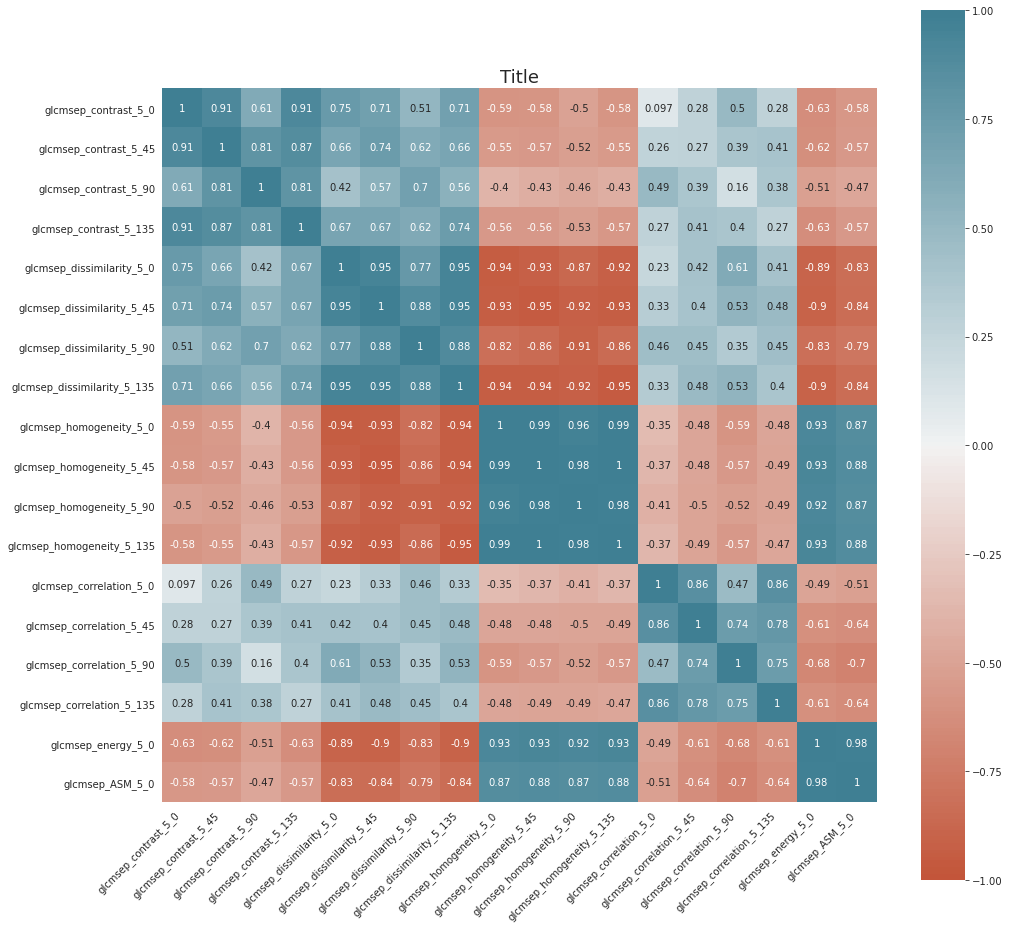

In [424]:
features_of_interest = [name for name in renamed_feature_names if (name.startswith('glcmsep_'))]

corr = df_features_copy[features_of_interest].corr()

fig_dims = (16, 16)
fig, ax = plt.subplots(figsize=fig_dims)
plt.title(f'Title', fontsize=18)

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, annot=True,
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

seaborn version = 0.11.1


Text(0, 0.5, 'Count')

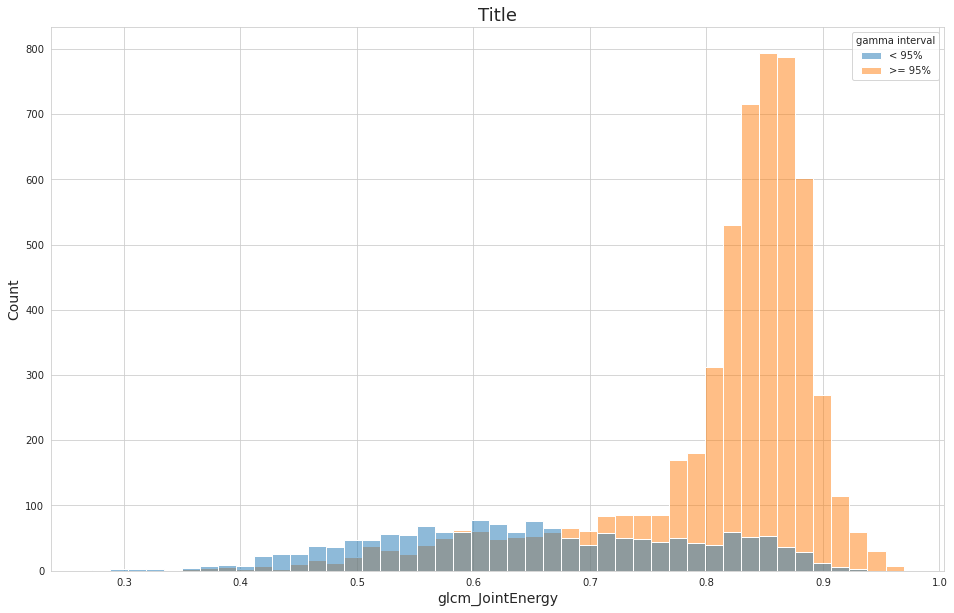

In [419]:
import seaborn as sns
from matplotlib import pyplot as plt
print(f'seaborn version = {sns.__version__}')

feature = 'glcm_JointEnergy'
fig_dims = (16, 10)
fig, ax = plt.subplots(figsize=fig_dims)
plt.title(f'Title', fontsize=18)

sns.set_style("whitegrid")
ax = sns.histplot(data=df_features_copy, x=feature, hue='gamma interval')
ax.set_xlabel(feature, fontsize=14)
ax.set_ylabel("Count", fontsize=14)

## Compute PCA and t-SNE on texture features

In [435]:
# https://erdem.pl/2020/04/t-sne-clearly-explained
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

features_of_interest = [name for name in renamed_feature_names if (name.startswith('glrlm_')
                                                                   
                                                                   )]
# features_of_interest = features_of_interest + ['firstorder_Energy',
#  'firstorder_Entropy',
#  'firstorder_Variance']

pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_features_copy[features_of_interest].values)
df_features_copy['1st component'] = pca_result[:,0]
df_features_copy['2nd component'] = pca_result[:,1] 
df_features_copy['3rd component'] = pca_result[:,2]

np.set_printoptions(precision=2, suppress=True)
print('Varianza explicada por 3 componentes principales (%): {}'.format(pca.explained_variance_ratio_*100))

variance = 0.90 # explicar 80% de la varianza
pca2 = PCA(n_components=variance, svd_solver='full')
pca_result2 = pca2.fit_transform(df_features_copy[features_of_interest].values)
print(f"Cantidad de componentes para explicar un {variance*100}% de la varianza: {pca2.n_components_}")

Varianza explicada por 3 componentes principales (%): [91.36  8.62  0.01]
Cantidad de componentes para explicar un 90.0% de la varianza: 1


In [436]:
features_of_interest

['glrlm_GrayLevelNonUniformity',
 'glrlm_GrayLevelNonUniformityNormalized',
 'glrlm_GrayLevelVariance',
 'glrlm_HighGrayLevelRunEmphasis',
 'glrlm_LongRunEmphasis',
 'glrlm_LongRunHighGrayLevelEmphasis',
 'glrlm_LongRunLowGrayLevelEmphasis',
 'glrlm_LowGrayLevelRunEmphasis',
 'glrlm_RunEntropy',
 'glrlm_RunLengthNonUniformity',
 'glrlm_RunLengthNonUniformityNormalized',
 'glrlm_RunPercentage',
 'glrlm_RunVariance',
 'glrlm_ShortRunEmphasis',
 'glrlm_ShortRunHighGrayLevelEmphasis',
 'glrlm_ShortRunLowGrayLevelEmphasis']

<AxesSubplot:xlabel='1st component', ylabel='2nd component'>

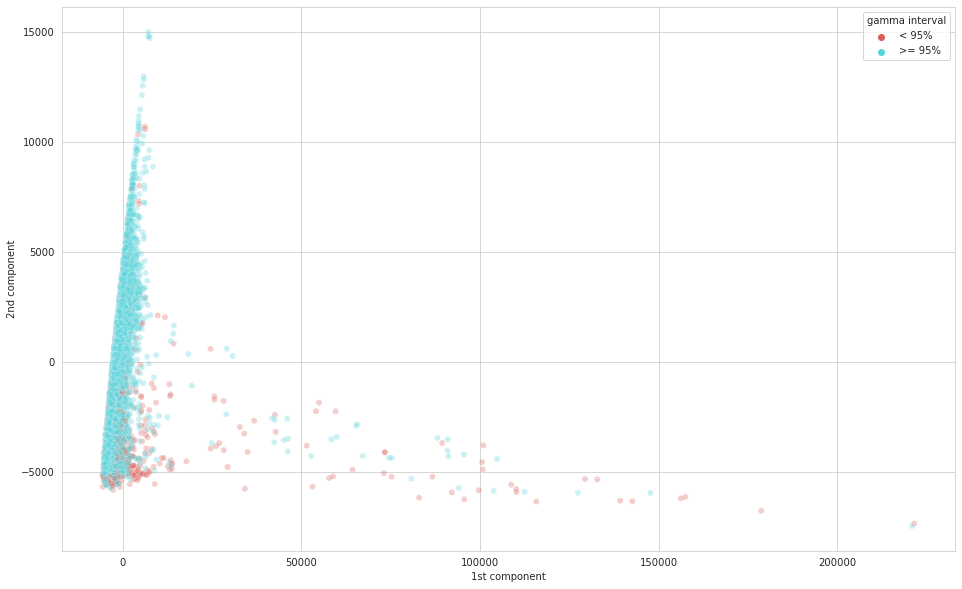

In [437]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="1st component", y="2nd component",
    hue='gamma interval',
    data=df_features_copy,
    legend="full",
    alpha=0.3,
    # palette=sns.color_palette("hls", 2)
    palette=sns.hls_palette(2)
)

In [440]:
import time
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=500, random_state=ARG_SEED)
tsne_results = tsne.fit_transform(df_features_copy[features_of_interest].values)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 7244 samples in 0.008s...
[t-SNE] Computed neighbors for 7244 samples in 0.383s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7244
[t-SNE] Computed conditional probabilities for sample 2000 / 7244
[t-SNE] Computed conditional probabilities for sample 3000 / 7244
[t-SNE] Computed conditional probabilities for sample 4000 / 7244
[t-SNE] Computed conditional probabilities for sample 5000 / 7244
[t-SNE] Computed conditional probabilities for sample 6000 / 7244
[t-SNE] Computed conditional probabilities for sample 7000 / 7244
[t-SNE] Computed conditional probabilities for sample 7244 / 7244
[t-SNE] Mean sigma: 44.893371
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.458855
[t-SNE] KL divergence after 500 iterations: 0.668994
t-SNE done! Time elapsed: 26.505041122436523 seconds


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

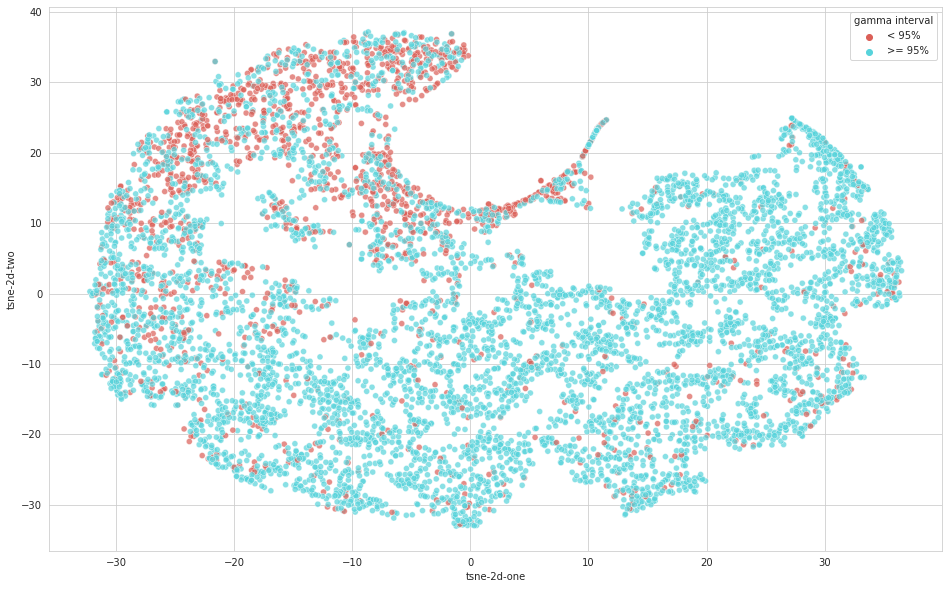

In [441]:
df_features_copy['tsne-2d-one'] = tsne_results[:,0]
df_features_copy['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='gamma interval',
    palette=sns.hls_palette(2),
    data=df_features_copy,
    legend="full",
    alpha=0.7
)

In [442]:
import xgboost as xgb
print('XGBoost version = {}'.format(xgb.__version__))

XGBoost version = 1.3.3


## Train an XGBoost model with extracted CNN features in 2019+2017
Hago cross-validation usando XGBoost directamente. Para cada métrica se informa, en cada iteración, la media y el desvío standard entre los k folds separados con '+', ej.: **test-rmse:71.88373+1.10987**.

CV con el Learning API (core) soporta early stopping.

In [515]:
# excluir mapas de 2018 para comparar con la CNN presentada en ASTRO:
X = df_features_copy
X['year2018'] = [path.find('2018-opencv') != -1 for path in X['jpeg_full_filepath']]
X = X[~X['year2018']]
y = X['gamma_index']
X = X[renamed_feature_names]
print(X.shape, y.shape)

X_train_cv = X
y_train_cv = y
print(X_train_cv.shape, y_train_cv.shape)

dtrain_cv = xgb.DMatrix(data=X_train_cv, label=y_train_cv)
print(f'DMatrix cols: {dtrain_cv.num_col()} rows: {dtrain_cv.num_row()}')

(4268, 107) (4268,)
(4268, 107) (4268,)
DMatrix cols: 107 rows: 4268


### Resultados con 2019+2018+2017
_train-mae:1.11119+0.00764	test-rmse:3.13041+0.08029	test-mae:1.94695+0.03_
```python
param = {'max_depth': 6 # or 'max_depth': 5 + 'colsample_bytree': 0.3
         , 'eta': 0.05
         , 'objective': 'reg:squarederror'
         , 'eval_metric': ['mae']
         # , 'colsample_bytree': 0.3
         # , 'colsample_bynode': 0.3
         , 'colsample_bylevel' : 0.3
         , 'lambda': 2
         , 'alpha': 2
         # , 'tree_method': 'gpu_hist' # usa la GPU
         , 'min_child_weight': 25
        }
```

### Resultados con 2019+2017
_[489]	train-rmse:1.27878+0.02592	train-mae:0.90220+0.01639	test-rmse:2.98198+0.14417	test-mae:1.92271+0.07347_
```python
param = {'max_depth': 5 # or 'max_depth': 5 + 'colsample_bytree': 0.3
         , 'eta': 0.05
         , 'objective': 'reg:squarederror'
         , 'eval_metric': ['mae']
         # , 'colsample_bytree': 0.3
         # , 'colsample_bynode': 0.3
         , 'colsample_bylevel' : 0.3
         , 'lambda': 2
         , 'alpha': 2
         # , 'tree_method': 'gpu_hist' # usa la GPU
         , 'min_child_weight': 20
        }
```

In [523]:
param = {'max_depth': 5 # or 'max_depth': 5 + 'colsample_bytree': 0.3
         , 'eta': 0.05
         , 'objective': 'reg:squarederror'
         , 'eval_metric': ['mae']
         # , 'colsample_bytree': 0.3
         # , 'colsample_bynode': 0.3
         , 'colsample_bylevel' : 0.3
         , 'lambda': 2
         , 'alpha': 2
         # , 'tree_method': 'gpu_hist' # usa la GPU
         , 'min_child_weight': 20
        }

print('running cross validation...')
bst = xgb.cv(param, dtrain_cv, nfold=5, num_boost_round=1000, early_stopping_rounds=10, metrics=['rmse', 'mae'],
             seed=ARG_SEED, shuffle=True, verbose_eval=True)

running cross validation...
[0]	train-rmse:90.55909+0.02940	train-mae:90.44146+0.03108	test-rmse:90.55960+0.12453	test-mae:90.44194+0.13112
[1]	train-rmse:86.04431+0.02781	train-mae:85.92465+0.02952	test-rmse:86.04480+0.12356	test-mae:85.92507+0.13053
[2]	train-rmse:81.75543+0.02627	train-mae:81.63344+0.02804	test-rmse:81.75671+0.12309	test-mae:81.63456+0.13036
[3]	train-rmse:77.68115+0.02482	train-mae:77.55653+0.02664	test-rmse:77.68257+0.12248	test-mae:77.55771+0.13010
[4]	train-rmse:73.81081+0.02340	train-mae:73.68323+0.02531	test-rmse:73.81204+0.12146	test-mae:73.68418+0.12940
[5]	train-rmse:70.13419+0.02206	train-mae:70.00337+0.02405	test-rmse:70.13542+0.12173	test-mae:70.00419+0.13009
[6]	train-rmse:66.64164+0.02082	train-mae:66.50727+0.02286	test-rmse:66.64219+0.12109	test-mae:66.50710+0.12972
[7]	train-rmse:63.32400+0.01966	train-mae:63.18579+0.02171	test-rmse:63.32410+0.12173	test-mae:63.18501+0.13073
[8]	train-rmse:60.17254+0.01847	train-mae:60.03017+0.02060	test-rmse:60.1713

[74]	train-rmse:3.42750+0.02799	train-mae:2.93195+0.02280	test-rmse:3.75128+0.08902	test-mae:3.13191+0.04811
[75]	train-rmse:3.35766+0.02823	train-mae:2.85363+0.02275	test-rmse:3.69243+0.09102	test-mae:3.05846+0.04905
[76]	train-rmse:3.29351+0.02713	train-mae:2.78083+0.02174	test-rmse:3.63867+0.09336	test-mae:2.99032+0.05018
[77]	train-rmse:3.23419+0.02901	train-mae:2.71289+0.02269	test-rmse:3.58957+0.09445	test-mae:2.92764+0.05069
[78]	train-rmse:3.17759+0.02927	train-mae:2.64830+0.02295	test-rmse:3.54453+0.09573	test-mae:2.86875+0.05026
[79]	train-rmse:3.12521+0.03080	train-mae:2.58810+0.02324	test-rmse:3.50222+0.09676	test-mae:2.81288+0.05009
[80]	train-rmse:3.07827+0.03078	train-mae:2.53249+0.02259	test-rmse:3.46420+0.09970	test-mae:2.76100+0.05207
[81]	train-rmse:3.03510+0.03032	train-mae:2.48024+0.02234	test-rmse:3.42933+0.10186	test-mae:2.71231+0.05322
[82]	train-rmse:2.99281+0.03202	train-mae:2.43016+0.02325	test-rmse:3.39740+0.10383	test-mae:2.66634+0.05438
[83]	train-rmse:2.9

[149]	train-rmse:2.20882+0.02997	train-mae:1.52695+0.01924	test-rmse:3.03530+0.14533	test-mae:1.99041+0.08169
[150]	train-rmse:2.20209+0.03106	train-mae:1.52195+0.01987	test-rmse:3.03444+0.14496	test-mae:1.98873+0.08126
[151]	train-rmse:2.19657+0.03220	train-mae:1.51812+0.02060	test-rmse:3.03347+0.14428	test-mae:1.98732+0.08085
[152]	train-rmse:2.19276+0.03279	train-mae:1.51507+0.02103	test-rmse:3.03282+0.14324	test-mae:1.98656+0.08039
[153]	train-rmse:2.18774+0.03116	train-mae:1.51127+0.02026	test-rmse:3.03146+0.14407	test-mae:1.98530+0.08076
[154]	train-rmse:2.18374+0.03086	train-mae:1.50856+0.02009	test-rmse:3.03152+0.14462	test-mae:1.98457+0.08129
[155]	train-rmse:2.17705+0.03016	train-mae:1.50374+0.01969	test-rmse:3.03132+0.14427	test-mae:1.98345+0.08090
[156]	train-rmse:2.17097+0.02953	train-mae:1.49970+0.01934	test-rmse:3.03130+0.14419	test-mae:1.98281+0.08137
[157]	train-rmse:2.16753+0.03038	train-mae:1.49682+0.02002	test-rmse:3.02995+0.14346	test-mae:1.98133+0.08068
[158]	trai

[224]	train-rmse:1.91775+0.02986	train-mae:1.32982+0.02000	test-rmse:3.01291+0.14518	test-mae:1.95889+0.08054
[225]	train-rmse:1.91412+0.03036	train-mae:1.32740+0.02061	test-rmse:3.01187+0.14517	test-mae:1.95795+0.08029
[226]	train-rmse:1.91040+0.02982	train-mae:1.32472+0.02023	test-rmse:3.01176+0.14525	test-mae:1.95756+0.08025
[227]	train-rmse:1.90702+0.02920	train-mae:1.32243+0.01967	test-rmse:3.01129+0.14541	test-mae:1.95695+0.08004
[228]	train-rmse:1.90284+0.02873	train-mae:1.31977+0.01926	test-rmse:3.01070+0.14545	test-mae:1.95672+0.07978
[229]	train-rmse:1.89967+0.02930	train-mae:1.31782+0.01948	test-rmse:3.01083+0.14596	test-mae:1.95688+0.08020
[230]	train-rmse:1.89561+0.02951	train-mae:1.31509+0.01939	test-rmse:3.01089+0.14611	test-mae:1.95697+0.08070
[231]	train-rmse:1.89304+0.02953	train-mae:1.31346+0.01941	test-rmse:3.01044+0.14596	test-mae:1.95675+0.08053
[232]	train-rmse:1.88882+0.03070	train-mae:1.31095+0.01999	test-rmse:3.00986+0.14569	test-mae:1.95603+0.08009
[233]	trai

[299]	train-rmse:1.69863+0.02846	train-mae:1.18624+0.01903	test-rmse:2.99721+0.14681	test-mae:1.94315+0.08033
[300]	train-rmse:1.69680+0.02805	train-mae:1.18509+0.01880	test-rmse:2.99717+0.14651	test-mae:1.94325+0.08005
[301]	train-rmse:1.69313+0.02728	train-mae:1.18254+0.01833	test-rmse:2.99662+0.14757	test-mae:1.94256+0.08034
[302]	train-rmse:1.69080+0.02731	train-mae:1.18114+0.01838	test-rmse:2.99645+0.14785	test-mae:1.94261+0.08039
[303]	train-rmse:1.68924+0.02756	train-mae:1.18002+0.01847	test-rmse:2.99631+0.14784	test-mae:1.94245+0.08064
[304]	train-rmse:1.68657+0.02708	train-mae:1.17813+0.01803	test-rmse:2.99588+0.14719	test-mae:1.94204+0.08048
[305]	train-rmse:1.68383+0.02700	train-mae:1.17619+0.01779	test-rmse:2.99533+0.14686	test-mae:1.94177+0.08056
[306]	train-rmse:1.68147+0.02730	train-mae:1.17454+0.01809	test-rmse:2.99507+0.14693	test-mae:1.94147+0.08046
[307]	train-rmse:1.67799+0.02642	train-mae:1.17230+0.01751	test-rmse:2.99504+0.14671	test-mae:1.94130+0.08041
[308]	trai

[374]	train-rmse:1.51705+0.02451	train-mae:1.06338+0.01609	test-rmse:2.98842+0.14442	test-mae:1.93297+0.07768
[375]	train-rmse:1.51502+0.02432	train-mae:1.06200+0.01583	test-rmse:2.98846+0.14439	test-mae:1.93290+0.07783
[376]	train-rmse:1.51200+0.02300	train-mae:1.05996+0.01499	test-rmse:2.98793+0.14464	test-mae:1.93228+0.07799
[377]	train-rmse:1.50983+0.02340	train-mae:1.05843+0.01524	test-rmse:2.98782+0.14439	test-mae:1.93212+0.07803
[378]	train-rmse:1.50757+0.02405	train-mae:1.05682+0.01562	test-rmse:2.98746+0.14421	test-mae:1.93182+0.07779
[379]	train-rmse:1.50477+0.02321	train-mae:1.05494+0.01531	test-rmse:2.98769+0.14420	test-mae:1.93193+0.07779
[380]	train-rmse:1.50242+0.02382	train-mae:1.05342+0.01555	test-rmse:2.98718+0.14410	test-mae:1.93138+0.07757
[381]	train-rmse:1.49948+0.02348	train-mae:1.05143+0.01523	test-rmse:2.98694+0.14394	test-mae:1.93126+0.07758
[382]	train-rmse:1.49726+0.02394	train-mae:1.04996+0.01561	test-rmse:2.98686+0.14399	test-mae:1.93112+0.07737
[383]	trai

[449]	train-rmse:1.35159+0.02614	train-mae:0.95139+0.01693	test-rmse:2.98367+0.14467	test-mae:1.92430+0.07513
[450]	train-rmse:1.35058+0.02600	train-mae:0.95073+0.01676	test-rmse:2.98381+0.14450	test-mae:1.92433+0.07512
[451]	train-rmse:1.34909+0.02641	train-mae:0.94977+0.01694	test-rmse:2.98403+0.14473	test-mae:1.92446+0.07528
[452]	train-rmse:1.34768+0.02674	train-mae:0.94882+0.01707	test-rmse:2.98374+0.14439	test-mae:1.92433+0.07514
[453]	train-rmse:1.34553+0.02603	train-mae:0.94752+0.01669	test-rmse:2.98361+0.14422	test-mae:1.92424+0.07517
[454]	train-rmse:1.34373+0.02555	train-mae:0.94638+0.01653	test-rmse:2.98345+0.14435	test-mae:1.92414+0.07502
[455]	train-rmse:1.34219+0.02552	train-mae:0.94543+0.01662	test-rmse:2.98311+0.14429	test-mae:1.92395+0.07502
[456]	train-rmse:1.34037+0.02543	train-mae:0.94414+0.01666	test-rmse:2.98319+0.14416	test-mae:1.92383+0.07475
[457]	train-rmse:1.33946+0.02562	train-mae:0.94349+0.01675	test-rmse:2.98309+0.14421	test-mae:1.92396+0.07486
[458]	trai

In [525]:
bst

,train-rmse-mean,train-rmse-std,train-mae-mean,train-mae-std,test-rmse-mean,test-rmse-std,test-mae-mean,test-mae-std
0,90.559093,0.029402,90.441463,0.031076,90.559602,0.124531,90.441939,0.131122
1,86.044313,0.027811,85.924654,0.029522,86.044801,0.123564,85.925073,0.130526
2,81.755426,0.026267,81.633435,0.028041,81.756712,0.123089,81.634556,0.130357
3,77.681148,0.024819,77.556532,0.026641,77.682567,0.122477,77.557714,0.130097
4,73.810808,0.023404,73.683234,0.025314,73.812039,0.121461,73.684184,0.129398
...,...,...,...,...,...,...,...,...
476,1.301939,0.023529,0.917945,0.014766,2.981616,0.144568,1.922461,0.074145
477,1.299944,0.023997,0.916681,0.014969,2.981412,0.144812,1.922373,0.074241
478,1.297988,0.023690,0.915458,0.014795,2.981678,0.144732,1.922440,0.073928
479,1.296685,0.023940,0.914445,0.014997,2.981696,0.144584,1.922388,0.073810
